# Stage 5 Defining Boundaries of Coronal Holes

In this stage, we will learn how to analyse EUV solar images. The example that we are going to do today is defining and drawing the boundaries of coronal holes (CH), dark region in solar corona.

Outline
1. Install relevant modules
2. Loading EUV images and prepared them
3. Defining the boundaries of CH using intensity threshold
4. Plot boundaries and make movies to look at evolution of CH

As always, if you want to save the changes you made from this notebook to your google drive, click 'Save a copy to Drive' from File menu.

## Installing the relevant modules

The first step here will be to get a module installed inside the jupyter notebook. To do that, just **run the following line the first time you open this notebook:**

In [ ]:
!pip install -q sunpy[all]  # This package is used for all things Sun-related, hosted in github: https://github.com/sunpy/sunpy
!pip install aiapy # This package is used for preparing data from AIA instruments onboard SDO.

**After the installation is finished, click on Runtime and Restart the Runtime with Control + M!**

Then we can start coding!! Normally, first few lines of python code are used to import library or package that will be used in the program.

In [ ]:
import glob

from os import makedirs as newdir
from os import path

import sunpy.map
from sunpy.net import attrs as a
from sunpy.net import Fido

from sunpy.map.maputils import all_pixel_indices_from_map,sample_at_coords,all_coordinates_from_map, coordinate_is_on_solar_disk

from aiapy.calibrate import normalize_exposure, register, update_pointing, correct_degradation

import numpy as np

from scipy import ndimage
from scipy.stats import mode

import matplotlib.pyplot as plt

import astropy.time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel, pixel_to_skycoord

import warnings
warnings.simplefilter('ignore')

from google.colab import drive

## Loading and Preparing EUV data
We will access google drive to retrieve the data (Don't forget to check whether you have 'Add shortcut to drive' from the data folders in the link we gave you).


In [ ]:
drive.mount('/content/drive')

Next, we will access all the data files (.fits file) inside the folder, and read one of the data file

In [ ]:
filelist_AIA = sorted(glob.glob('/content/drive/MyDrive/PythonWorkshop/Sampledata_AIA193/*.fits'))
# Select first file (first element => index 0) 
# You can change the image file by changing the index number
fileAIA = filelist_AIA[0]
aiamap = sunpy.map.Map(fileAIA)

Since we are using the data for analysis purposes, we have to prepare the data according to standard routine. Below is the function for preparing AIA data.

In [ ]:
#Function use to prepare map obtained from AIA
def aiaprep(aiamap):
    aiamap_updated_pointing = update_pointing(aiamap) #update metadata to recent pointing
    aiamap_registered = register(aiamap_updated_pointing) #registered: rotate align w/ solar north and rescale to match 0.6 pixel resolution
    aiamap_norm = normalize_exposure(aiamap_registered) #Normalized exposure time for each image: unit (DN/pixel/s)
    aiamap_corr = correct_degradation(aiamap_norm) #Correct Degradation effect of Instrument
    aiamap_rot = aiamap_corr.rotate()

    return aiamap_rot

We then apply this function to our data. The prepped data is now called aiamap_prep

In [ ]:
aiamap_prep = aiaprep(aiamap) #input is full sun image file

We can have a quicklook of the map using .peek() method on the data (Only available on sunpy)

In [ ]:
aiamap_prep.peek()

The map showed that there is a coronal hole in the solar disc. Next step is to choosing an appropriate field of view, so we can focus mainly on CH. This new FOV are called submap.

You will required to specify the coordinate of bottomleft corner, the height and width of our zoom in map

In [ ]:
# Choose submap region
bottom_left_x = -600 #x coordinate of bottomleft corner
bottom_left_y = -400 #y coordinate of bottomleft corner
bottom_left = SkyCoord(bottom_left_x * u.arcsec, bottom_left_y* u.arcsec, frame= aiamap_prep.coordinate_frame)
# Define width and height for our zoomed-in map
w = 800 #Width
h = 1000 #Height
# Crop our map using submap function
subaiamap = aiamap_prep.submap(bottom_left, width = w*u.arcsec, height = h*u.arcsec)
subaiamap_mask = aiamap_prep.submap(bottom_left, width = w*u.arcsec, height = h*u.arcsec)

Note that we have created two submap, which will come in hand later.
We can also have a quicklook at the submap, to make sure we get appropriate FOV

In [ ]:
subaiamap.peek()

## Finding correct threshold for CH boundaries
If we look at the map, we can see that the CH appears darker than surrounding regions, which means that the pixel corresponding with CH region must have lower intensity. Therefore, maybe we can define a threshold of intensity which will categorise if the pixel is inside CH or not.

Your task is to find the threshold that will return the appropriate CH boundary.

The good place to start is looking at the distribution of pixel inside the map based on intensity. We can do that by plotting a histogram.

In [ ]:
# Define the number of bins: The number of bins will affect the shape of distribution
num_bins = 1000
bins = np.linspace(subaiamap.min(), subaiamap.max(), num_bins)

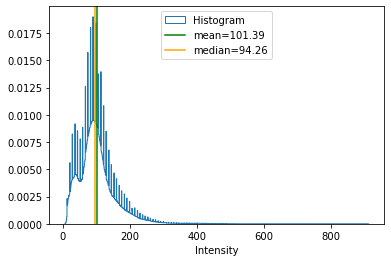

In [ ]:
# Plot Histogram
fig = plt.figure()
plt.hist(subaiamap.data.ravel(), bins=bins, label='Histogram', histtype='step' ,density = True)
plt.xlabel('Intensity')
plt.axvline(subaiamap.data.mean(),
            label='mean={:.2f}'.format(subaiamap.data.mean()), color='green')
plt.axvline(np.median(subaiamap.data),
            label='median={:.2f}'.format(np.median(subaiamap.data)), color='Orange')
plt.legend(loc=9)
# Set the limit of x axis to zoomed in at specific range 
# (Hint: appropriate range is x-axis can be helpful)
# plt.xlim(0,200)

Using the histogram we plotted above to figure out what the threshold should be. After you have an initial guess, you can put the value you guess in a variable name 'thr'.

In [1]:
# Change the value of thr to your guess
thr = 40 
print(thr)

The function **define_CHB** below are used to define coronal hole boundaries.

In [ ]:
#Function used to mask the area outside solar disc
def mask_solardisc(subaiamap):
    hpc = all_coordinates_from_map(subaiamap)
    mask = coordinate_is_on_solar_disk(hpc)
    return mask

#Define Coronal Hole Boundary - Return results as the array where CH pixels are defined as 1 and anywhere else are defined as 0
def define_CHB (aiamap, subaiamap, subaiamap_mask, thr, filt_order=5): 
    mask_disk = mask_solardisc(subaiamap)
    mask_disk_full = mask_solardisc(aiamap)
    #Make the data outside solar disk = 0
    aiamap_data_disk = np.where(mask_disk_full, aiamap.data, 0)
    #Select CHB according to given threshold
    mask = subaiamap.data > thr
    subaiamap_mask.mask = mask
    #Gaussian Filtering to Connect Smaller Region and smooth boundary
    data1 = ndimage.gaussian_filter(subaiamap.data * ~mask, filt_order) #gaussian filtering
    #labels the area define in CH
    subaiamap_new = sunpy.map.Map(data1, subaiamap.meta)
    labels, n = ndimage.label(subaiamap_new.data)
    #Select only biggest CH
    vallabel = mode(labels[np.nonzero(labels)])
    labels_true = np.where(labels == vallabel[0], labels, 0)
    #Fill Bright spots in CH (We neglected them)
    labels_true = ndimage.binary_fill_holes(labels_true).astype(int)
    # Check only coordinate on disk
    labels_true = np.where(mask_disk, labels_true,0)
    return labels_true

This function will return array named 'CHB', which the same shape of our input submap. But it will mark area inside our target CH as 1 and outside CH as 0.

In [ ]:
# input are (full sun map, submap, a copy of submap(mask), threshold value)
CHB = define_CHB(aiamap, subaiamap, subaiamap_mask, thr = 40)

Then let's try to plot our defined boundary onto our zoom-in map

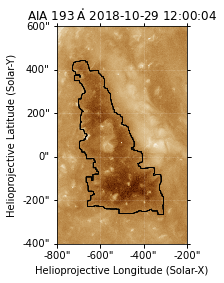

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection = subaiamap)
subaiamap.plot()
# ax.contour will draw a contour around boundary between 0 and 1 in CHB array, which is the boundary of CH
ax.contour(CHB, colors='black', linewidths = 0.5) #You can change color and linewidths

Now you can redo the define process using different threshold until you get the appropriate CH. There is no definite answer or value, just trying to adjust it until you are satisfied with the results :)

When we get the appropriate threshold. we can save our plots as images (png or jpg) using savefig function. (You can also right click at the image to save them.). We will save the images onto newly created folder on google drive named 'My_pics'

In [ ]:
dir_png = '/content/drive/MyDrive/My_pics/'
newdir(dir_png, exist_ok = True)
# Save plots using savefig we can also have option such as choosing name, select the resolution or eliminate white space
fig.savefig(dir_png+'CHB_AIA193.png', dpi=200, bbox_inches='tight')

**EXTRA:** We can get the coordinate of the boundary, which will be useful when we want to plot them onto other maps. We can do it using the function below

In [ ]:
def getboundarycoord(labels, subaia):
    maskinner =  ndimage.binary_erosion(labels.tolist())
    labels[maskinner] = 0
    CHB_pixel = np.nonzero(labels)
    CHB_pixel_array = np.column_stack((CHB_pixel[1],CHB_pixel[0]))
    xpixelaia = CHB_pixel_array[:,0]
    ypixelaia = CHB_pixel_array[:,1]
    subaiamapwcs = subaia.wcs
    aia_subarea_sky = pixel_to_skycoord(xpixelaia,ypixelaia,subaiamapwcs,origin=0)
    return aia_subarea_sky

In [ ]:
CHB_coord = getboundarycoord(CHB, subaiamap)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection = aiamap)
aiamap.plot()
# ax.plot_coord will plot the coordinate, in this case is our CH boundary
ax.plot_coord(CHB_coord, colors='black', linewidths = 0.5) #You can change color and linewidths

## Bonus: Making movies to study the evolution of CH
Using what we have learned from Stage 4 and this stage, Let's write a code to create a movies for studying the evolution of this coronal hole

Hint: 
1. Using for loop to make png images from all dataset first, then create movies from png images.
2. If we use threshold value based on median value of intensity, it may yield better results at identifying CH.